In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats
from arch import arch_model

In [2]:
PBK_df = pd.read_excel(io='03_Nguyễn Thị Minh Anh.xlsx', sheet_name='PBK')
PBK_df

,Date,PBK
0,2015-01-01,1213.40
1,2015-01-02,1203.20
2,2015-01-04,1202.00
3,2015-01-05,1212.95
4,2015-01-06,1219.65
...,...,...
2483,2022-12-26,1036.00
2484,2022-12-27,1032.70
2485,2022-12-28,1019.80
2486,2022-12-29,1065.00


In [3]:
PP_df = pd.read_excel(io='03_Nguyễn Thị Minh Anh.xlsx', sheet_name='PP')
PP_df

,Date,PP
0,2015-01-01,796.30
1,2015-01-02,794.85
2,2015-01-05,793.20
3,2015-01-06,800.40
4,2015-01-07,792.45
...,...,...
2319,2022-12-26,1763.00
2320,2022-12-27,1826.30
2321,2022-12-28,1785.00
2322,2022-12-29,1824.10


In [4]:
PB_df = pd.read_excel(io='03_Nguyễn Thị Minh Anh.xlsx', sheet_name='PB')
PB_df

,Date,PB
0,2015-01-02,15.768
1,2015-01-05,16.213
2,2015-01-06,16.637
3,2015-01-07,16.544
4,2015-01-08,16.385
...,...,...
2046,2022-12-26,24.055
2047,2022-12-27,24.217
2048,2022-12-28,23.840
2049,2022-12-29,24.250


## PBK

### 1. Data preparation

In [5]:
df_pbk = PBK_df.copy()
df_pbk = df_pbk.set_index('Date')
df_pbk.index = pd.to_datetime(df_pbk.index)
df_pbk

,PBK
Date,
2015-01-01,1213.40
2015-01-02,1203.20
2015-01-04,1202.00
2015-01-05,1212.95
2015-01-06,1219.65
...,...
2022-12-26,1036.00
2022-12-27,1032.70
2022-12-28,1019.80


In [6]:
df_data_pbk = PBK_df.copy()
df_data_pbk = df_data_pbk.to_numpy()
data_pbk = df_data_pbk[:, 1]
data_pbk = np.float32(data_pbk)
data_pbk

array([1213.4, 1203.2, 1202. , ..., 1019.8, 1065. , 1082.9], dtype=float32)

In [7]:
# Tính toán tỷ suất sinh lợi
r_pbk= np.diff(np.log(data_pbk), n=1, axis=0)

In [8]:
r_pbk

array([-0.00844145, -0.00099802,  0.00906849, ..., -0.0125699 ,
        0.04336834,  0.01666784], dtype=float32)

In [9]:
df_r_pbk_temp = PBK_df.copy()
df_r_pbk_temp.drop(axis=0, index=[0], inplace=True)
df_r_pbk_temp

,Date,PBK
1,2015-01-02,1203.20
2,2015-01-04,1202.00
3,2015-01-05,1212.95
4,2015-01-06,1219.65
5,2015-01-07,1220.65
...,...,...
2483,2022-12-26,1036.00
2484,2022-12-27,1032.70
2485,2022-12-28,1019.80
2486,2022-12-29,1065.00


In [10]:
df_r_pbk_temp['Return'] = r_pbk
df_r_pbk_temp.drop(axis=1, columns='PBK', inplace=True)
df_r_pbk_temp = df_r_pbk_temp.set_index('Date')
df_r_pbk_temp.index = pd.to_datetime(df_r_pbk_temp.index)
df_r_pbk_temp

,Return
Date,
2015-01-02,-0.008441
2015-01-04,-0.000998
2015-01-05,0.009068
2015-01-06,0.005509
2015-01-07,0.000819
...,...
2022-12-26,0.006196
2022-12-27,-0.003191
2022-12-28,-0.012570


### 2. Visualize

In [11]:
# Hàm vẽ đồ thị giá và tỷ suất sinh lợi
def visualize_return_value(df: pd.DataFrame,
                           df_r: pd.DataFrame,
                           df_name: str,
                           df_r_name: str)->None:
    fig, ax= plt.subplots(2,1, figsize=(15,8))
    ax[0].plot(df, color='black')
    ax[0].title.set_text(df_name)
    ax[0].set(xlabel='Year', ylabel='Price')
    ax[0].grid(True)
    ax[1].plot(df_r, color='red')
    ax[1].title.set_text(df_r_name)
    ax[1].set(xlabel='Year', ylabel='Returns')
    ax[1].grid(True)
    plt.tight_layout()

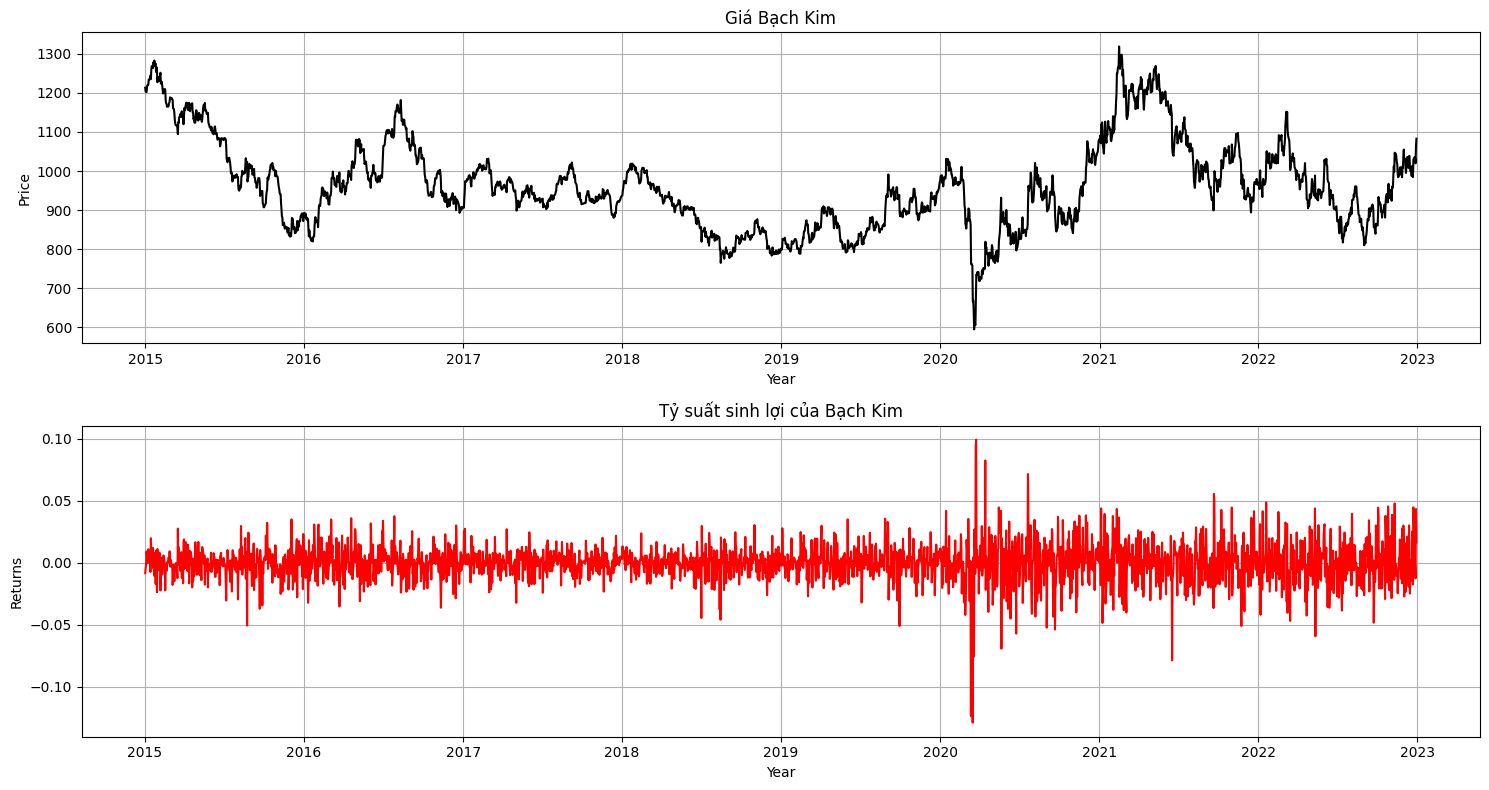

In [12]:
visualize_return_value(df=df_pbk,
                       df_r=df_r_pbk_temp,
                       df_name='Giá Bạch Kim',
                       df_r_name='Tỷ suất sinh lợi của Bạch Kim')

### 3. Descriptive Statistic

In [13]:
# Hàm thống kê mô tả
def descriptive_statistic(r: np.ndarray)->None:
    print('Obs       :', len(r))
    print('Median    :', np.median(r))
    print('Mean      :', np.mean(r))
    print('Std. Dev  :', np.std(r, ddof=1))
    print('Minimum   :', np.min(r))
    print('Maximum   :', np.max(r))
    print('Skewness  :', stats.skew(r))
    print('Kurtosis  :', stats.kurtosis(r, fisher = False))
    print('Jarque-Bera test:', stats.jarque_bera(r))

In [14]:
# Hàm kiểm định tính dừng
def adf_test(r: np.ndarray)->None:
    adf = adfuller(r)
    print('ADF Statistic:', adf[0])
    print('p-value:', adf[1])
    print('Critical Values:', adf[4])

In [15]:
descriptive_statistic(r=r_pbk)

Obs       : 2487
Median    : 0.00026273727
Mean      : -4.575125e-05
Std. Dev  : 0.0151277315
Minimum   : -0.12903643
Maximum   : 0.099313736
Skewness  : -0.3310558080076415
Kurtosis  : 9.866806468488578
Jarque-Bera test: SignificanceResult(statistic=4931.661194669448, pvalue=0.0)


In [16]:
adf_test(r=r_pbk)

ADF Statistic: -18.065182002861913
p-value: 2.614306163929337e-30
Critical Values: {'1%': -3.4329927491693426, '5%': -2.8627075477802673, '10%': -2.567391531704927}


### 4. ARCH(1)

In [17]:
dist = 'normal'

In [18]:
#Chuyển TSSL sang dạng % cho thuận tiện
rp_pbk = r_pbk*100

In [19]:
#Ước lượng mô hình ARCH(1)
am0_pbk = arch_model(rp_pbk, mean = 'Constant', p=1, o=0, q=0, dist=dist)
arch1_pbk = am0_pbk.fit(update_freq=5, disp = "off")
print("ARCH(1) model:", "\n", arch1_pbk.summary(), "\n")

#Kiểm định phần dư của ARCH(1)
arch_stdresid= arch1_pbk.resid/arch1_pbk.conditional_volatility
arch1lb = acorr_ljungbox(arch_stdresid, lags=[5,10,15,20]) 
print('LB Test Result:','\n',arch1lb)
jb_arch = jarque_bera(arch_stdresid)
print('\nJB Test Result:','\n',jb_arch)

ARCH(1) model: 
                       Constant Mean - ARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -4516.56
Distribution:                  Normal   AIC:                           9039.13
Method:            Maximum Likelihood   BIC:                           9056.58
                                        No. Observations:                 2487
Date:                Sat, Jun 15 2024   Df Residuals:                     2486
Time:                        15:09:40   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -6.8735e-03  2.856e-02  

In [20]:
# LM test
arch1_pbk.arch_lm_test(standardized=True)

ARCH-LM Test
H0: Standardized residuals are homoskedastic.
ARCH-LM Test
H1: Standardized residuals are conditionally heteroskedastic.
Statistic: 429.6226
P-value: 0.0000
Distributed: chi2(27)
WaldTestStatistic, id: 0x28fdd925280

### 5. GARCH(1, 1)

In [21]:
#Ước lượng mô hình GARCH(1,1)
am1_pbk = arch_model(rp_pbk, mean = 'Constant', vol='GARCH', p=1, o=0, q=1, dist=dist)
garch1_1_pbk = am1_pbk.fit(update_freq=5, disp = "off")
print("GARCH(1,1) model:", "\n", garch1_1_pbk.summary(), "\n")

#Kiểm định phần dư của GARCH(1,1)
garch_stdresid= garch1_1_pbk.resid/garch1_1_pbk.conditional_volatility
garch11lb = acorr_ljungbox(garch_stdresid, lags=[5,10,15,20]) 
print('LB Test Result:','\n',garch11lb)
jb_arch = jarque_bera(garch_stdresid)
print('\nJB Test Result:','\n',jb_arch)

GARCH(1,1) model: 
                      Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4300.40
Distribution:                  Normal   AIC:                           8608.79
Method:            Maximum Likelihood   BIC:                           8632.07
                                        No. Observations:                 2487
Date:                Sat, Jun 15 2024   Df Residuals:                     2486
Time:                        15:09:40   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu            -0.0175  2.431e-02   

### 6. GJR-GARCH(1,1)

In [22]:
#Ước lượng mô hình TGARCH(1,1)
am2_pbk = arch_model(rp_pbk, mean = 'Constant', vol='GARCH', p=1, o=1, q=1, dist=dist)
gjr_garch1_1_pbk = am2_pbk.fit(update_freq=5, disp = "off")
print("GJR-GARCH(1,1) model:", "\n", gjr_garch1_1_pbk.summary(), "\n")

#Kiểm định phần dư của TGARCH(1,1)
gjr_garch_stdresid= gjr_garch1_1_pbk.resid/gjr_garch1_1_pbk.conditional_volatility
gjr_garch11lb = acorr_ljungbox(gjr_garch_stdresid, lags=[5,10,15,20]) 
print('LB Test Result:','\n',gjr_garch11lb)
jb_arch = jarque_bera(gjr_garch_stdresid)
print('\nJB Test Result:','\n',jb_arch)

GJR-GARCH(1,1) model: 
                    Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -4296.69
Distribution:                  Normal   AIC:                           8603.39
Method:            Maximum Likelihood   BIC:                           8632.48
                                        No. Observations:                 2487
Date:                Sat, Jun 15 2024   Df Residuals:                     2486
Time:                        15:09:40   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu            -0.0262  2.465e-0

### 7. EGARCH(1,1)

In [23]:
#Ước lượng mô hình EGARCH(1,1)
am3_pbk = arch_model(rp_pbk, mean = 'Constant', vol='EGARCH', p=1, o=1, q=1, dist=dist)
exponetial_garch1_1 = am3_pbk.fit(update_freq=5, disp = "off")
print("EGARCH(1,1) model:", "\n", exponetial_garch1_1.summary(), "\n")

#Kiểm định phần dư của TGARCH(1,1)
egarch_stdresid= exponetial_garch1_1.resid/exponetial_garch1_1.conditional_volatility
egarch11lb = acorr_ljungbox(egarch_stdresid, lags=[5,10,15,20]) 
print('LB Test Result:','\n',egarch11lb)
jb_arch = jarque_bera(egarch_stdresid)
print('\nJB Test Result:','\n',jb_arch)

EGARCH(1,1) model: 
                      Constant Mean - EGARCH Model Results                     
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -4301.29
Distribution:                  Normal   AIC:                           8612.59
Method:            Maximum Likelihood   BIC:                           8641.68
                                        No. Observations:                 2487
Date:                Sat, Jun 15 2024   Df Residuals:                     2486
Time:                        15:09:40   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu            -0.0339  2.526e-02  

### 8. Evaluate

In [24]:
def tic(forecast, actual):
    sse = np.sum((forecast - actual)**2)  
    starch = np.sum((actual - np.mean(actual))**2)
    return np.sqrt(sse/starch)

In [25]:
# Hàm đánh giá sai số
def evaluate_error_of_model(model: arch_model)->list:
    res = model.fit(last_obs=1987, update_freq=5, disp='off')
    forecasts = res.forecast(horizon=1)
    forecast_vals = forecasts.residual_variance.values[-10:]
    actual_vals = rp_pbk[-10:]
    
    rmse = np.sqrt(mean_squared_error(actual_vals, forecast_vals))
    mae = mean_absolute_error(actual_vals, forecast_vals)
    mape = np.mean(np.abs(forecast_vals - actual_vals)/np.abs(actual_vals))
    tic_value = tic(forecast_vals, actual_vals)
    
    return rmse, mae, mape, tic_value

In [26]:
# Đánh giá sai số của mô hình ARCH(1)
rmse_arch1_pbk, mae_arch1_pbk, mape_arch1_pbk, tic_arch1_pbk = evaluate_error_of_model(model=am0_pbk)
print('ARCH(1):')
print('RMSE: %0.3f' % rmse_arch1_pbk)
print('MAE: %0.3f' % mae_arch1_pbk) 
print('MAPE: %0.3f' % mape_arch1_pbk)
print('TIC: % 0.3f' % tic_arch1_pbk)

ARCH(1):
RMSE: 2.309
MAE: 1.870
MAPE: 2.633
TIC:  4.453


In [27]:
# Đánh giá sai số của mô hình GARCH(1,1)
rmse_garch11_pbk, mae_garch11_pbk, mape_garch11_pbk, tic_garch11_pbk = evaluate_error_of_model(model=am1_pbk)
print('GARCH(1,1):')
print('RMSE: %0.3f' % rmse_garch11_pbk)
print('MAE: %0.3f' % mae_garch11_pbk) 
print('MAPE: %0.3f' % mape_garch11_pbk)
print('TIC: % 0.3f' % tic_garch11_pbk)

GARCH(1,1):
RMSE: 3.434
MAE: 2.966
MAPE: 3.331
TIC:  5.036


In [28]:
# Đánh giá sai số của mô hình GJR-ARCH(1,1)
rmse_gjr_garch11_pbk, mae_gjr_garch11_pbk, mape_gjr_garch11_pbk, tic_gjr_garch11_pbk = evaluate_error_of_model(model=am2_pbk)
print('GJR-GARCH(1,1):')
print('RMSE: %0.3f' % rmse_gjr_garch11_pbk)
print('MAE: %0.3f' % mae_gjr_garch11_pbk) 
print('MAPE: %0.3f' % mape_gjr_garch11_pbk)
print('TIC: % 0.3f' % tic_gjr_garch11_pbk)

GJR-GARCH(1,1):
RMSE: 3.235
MAE: 2.831
MAPE: 3.057
TIC:  4.672


In [29]:
# Đánh giá sai số của mô hình EGARCH(1,1)
rmse_egarch11_pbk, mae_egarch11_pbk, mape_egarch11_pbk, tic_egarch11_pbk = evaluate_error_of_model(model=am3_pbk)
print('EGARCH(1,1):')
print('RMSE: %0.3f' % rmse_egarch11_pbk)
print('MAE: %0.3f' % mae_egarch11_pbk) 
print('MAPE: %0.3f' % mape_egarch11_pbk)
print('TIC: % 0.3f' % tic_egarch11_pbk)

EGARCH(1,1):
RMSE: 3.771
MAE: 3.229
MAPE: 3.604
TIC:  5.393


In [30]:
RMSE_value=[rmse_arch1_pbk, rmse_garch11_pbk, rmse_gjr_garch11_pbk, rmse_egarch11_pbk]
best_RMSEprediction= np.argmin(RMSE_value)
print('\nBest Forecasting Model (Lowest RMSE):', ['ARCH(1)', 'GARCH(1,1)', 'GJR-GARCH(1_1)', 'EGARCH(1_1)'][best_RMSEprediction])

MAE_value=[mae_arch1_pbk, mae_arch1_pbk, mae_gjr_garch11_pbk, mae_egarch11_pbk]
best_MAEprediction= np.argmin(MAE_value)
print('\nBest Forecasting Model (Lowest MAE):', ['ARCH(1)', 'GARCH(1,1)', 'GJR-GARCH(1_1)', 'EGARCH(1_1)'][best_MAEprediction])

MAPE_value=[mape_arch1_pbk, mape_garch11_pbk, mape_gjr_garch11_pbk, mape_egarch11_pbk]
best_MAPEprediction= np.argmin(MAPE_value)
print('\nBest Forecasting Model (Lowest MAPE):', ['ARCH(1)', 'GARCH(1,1)', 'GJR-GARCH(1_1)', 'EGARCH(1_1)'][best_MAPEprediction])

TIC_value=[tic_arch1_pbk, tic_garch11_pbk, tic_gjr_garch11_pbk, tic_egarch11_pbk]
best_TICprediction= np.argmin(TIC_value)
print('\nBest Forecasting Model (Lowest TIC):', ['ARCH(1)', 'GARCH(1,1)', 'GJR-GARCH(1_1)', 'EGARCH(1_1)'][best_TICprediction])


Best Forecasting Model (Lowest RMSE): ARCH(1)

Best Forecasting Model (Lowest MAE): ARCH(1)

Best Forecasting Model (Lowest MAPE): ARCH(1)

Best Forecasting Model (Lowest TIC): ARCH(1)


## PP

### 1. Data preparation

In [31]:
df_pp = PP_df.copy()
df_pp = df_pp.set_index('Date')
df_pp.index = pd.to_datetime(df_pp.index)
# df = df.to_numpy()
df_pp

,PP
Date,
2015-01-01,796.30
2015-01-02,794.85
2015-01-05,793.20
2015-01-06,800.40
2015-01-07,792.45
...,...
2022-12-26,1763.00
2022-12-27,1826.30
2022-12-28,1785.00


In [32]:
df_data_pp = PP_df.copy()
df_data_pp = df_data_pp.to_numpy()
data_pp = df_data_pp[:, 1]
data_pp = np.float32(data_pp)
data_pp

array([ 796.3 ,  794.85,  793.2 , ..., 1785.  , 1824.1 , 1806.7 ],
      dtype=float32)

In [33]:
r_pp = np.diff(np.log(data_pp), n=1, axis=0)
r_pp

array([-0.00182247, -0.00207806,  0.00903606, ..., -0.02287388,
        0.02166843, -0.0095849 ], dtype=float32)

In [34]:
df_r_pp_temp = PP_df.copy()
df_r_pp_temp.drop(axis=0, index=[0], inplace=True)
df_r_pp_temp

,Date,PP
1,2015-01-02,794.85
2,2015-01-05,793.20
3,2015-01-06,800.40
4,2015-01-07,792.45
5,2015-01-08,793.10
...,...,...
2319,2022-12-26,1763.00
2320,2022-12-27,1826.30
2321,2022-12-28,1785.00
2322,2022-12-29,1824.10


In [35]:
df_r_pp_temp['Return'] = r_pp
df_r_pp_temp.drop(axis=1, columns='PP', inplace=True)
df_r_pp_temp = df_r_pp_temp.set_index('Date')
df_r_pp_temp.index = pd.to_datetime(df_r_pp_temp.index)
df_r_pp_temp

,Return
Date,
2015-01-02,-0.001822
2015-01-05,-0.002078
2015-01-06,0.009036
2015-01-07,-0.009982
2015-01-08,0.000820
...,...
2022-12-26,0.017740
2022-12-27,0.035275
2022-12-28,-0.022874


### 2. Visualize

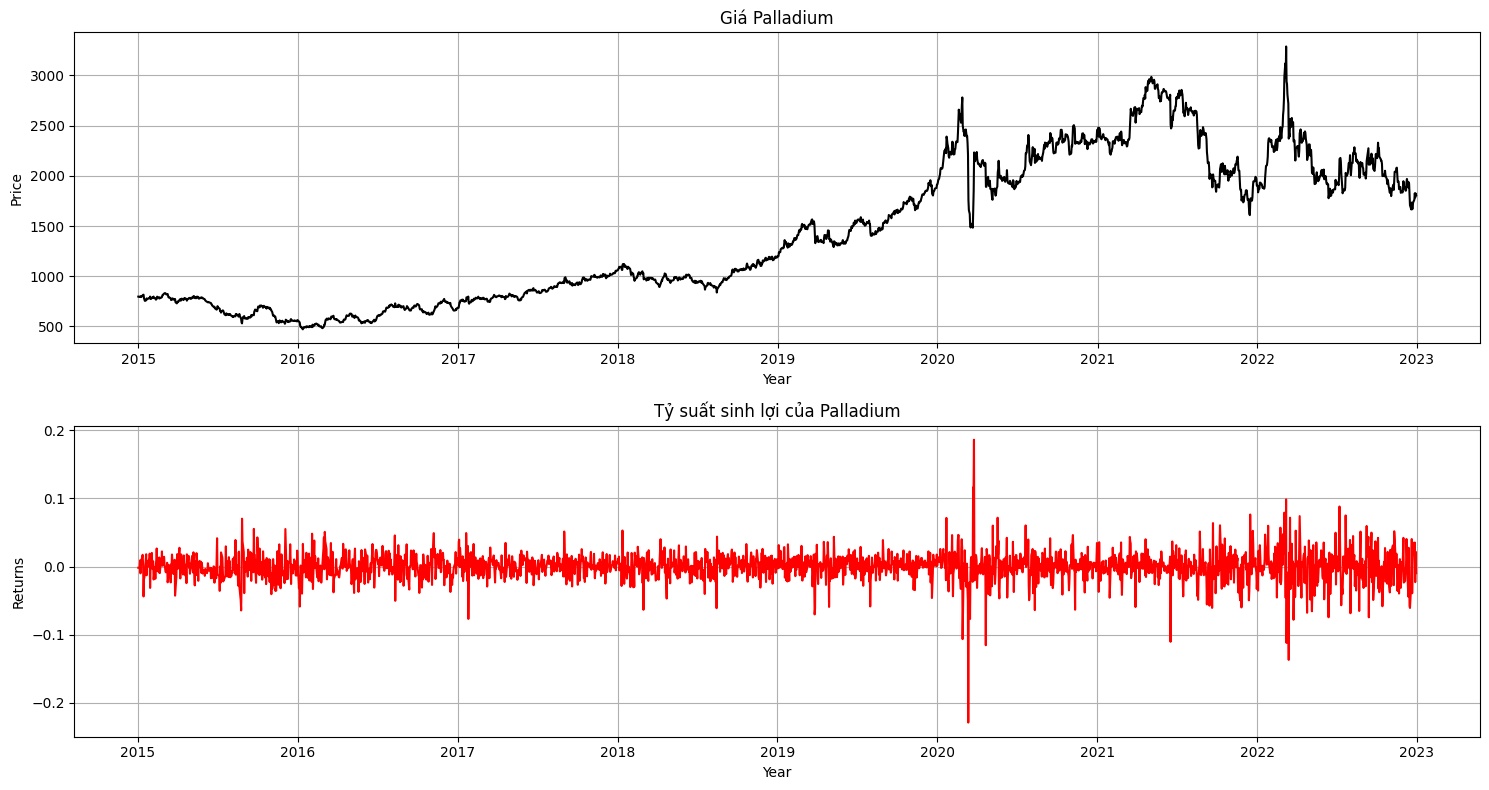

In [36]:
visualize_return_value(df=df_pp,
                       df_r=df_r_pp_temp,
                       df_name='Giá Palladium',
                       df_r_name='Tỷ suất sinh lợi của Palladium')

### 3. Description Statistic

In [37]:
descriptive_statistic(r=r_pp)

Obs       : 2323
Median    : 0.0010352135
Mean      : 0.00035268234
Std. Dev  : 0.021187821
Minimum   : -0.22917128
Maximum   : 0.18627024
Skewness  : -0.5590508793995949
Kurtosis  : 14.868310770307795
Jarque-Bera test: SignificanceResult(statistic=13754.768757804628, pvalue=0.0)


In [38]:
adf_test(r=r_pp)

ADF Statistic: -13.131759190992547
p-value: 1.4897734287826174e-24
Critical Values: {'1%': -3.433195115207185, '5%': -2.8627969090099765, '10%': -2.567439109419199}


### 4. ARCH(1)

In [39]:
#Chuyển TSSL sang dạng % cho thuận tiện
rp_pp = r_pp*100

In [40]:
#Ước lượng mô hình ARCH(1)
am0_pp = arch_model(rp_pp, mean = 'Constant', p=1, o=0, q=0, dist=dist)
arch1_pp = am0_pp.fit(update_freq=5, disp = "off")
print("ARCH(1) model:", "\n", arch1_pp.summary(), "\n")
#Kiểm định phần dư của ARCH(1)
arch_stdresid= arch1_pp.resid/arch1_pp.conditional_volatility
arch1lb = acorr_ljungbox(arch_stdresid, lags=[5,10,15,20]) 
print('LB Test Result:','\n',arch1lb)
jb_arch = jarque_bera(arch_stdresid)
print('\nJB Test Result:','\n',jb_arch)


ARCH(1) model: 
                       Constant Mean - ARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -4906.77
Distribution:                  Normal   AIC:                           9819.55
Method:            Maximum Likelihood   BIC:                           9836.80
                                        No. Observations:                 2323
Date:                Sat, Jun 15 2024   Df Residuals:                     2322
Time:                        15:09:41   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0710  4.258e-02      1.667 

In [41]:
# LM test
arch1_pp.arch_lm_test(standardized=True)

ARCH-LM Test
H0: Standardized residuals are homoskedastic.
ARCH-LM Test
H1: Standardized residuals are conditionally heteroskedastic.
Statistic: 162.7666
P-value: 0.0000
Distributed: chi2(27)
WaldTestStatistic, id: 0x28fde0936b0

### 5. GARCH(1, 1)

In [42]:
#Ước lượng mô hình GARCH(1,1)
am1_pp = arch_model(rp_pp, mean = 'Constant', vol='GARCH', p=1, o=0, q=1, dist=dist)
garch1_1_pp = am1_pp.fit(update_freq=5, disp = "off")
print("GARCH(1,1) model:", "\n", garch1_1_pp.summary(), "\n")

#Kiểm định phần dư của GARCH(1,1)
garch_stdresid= garch1_1_pp.resid/garch1_1_pp.conditional_volatility
garch11lb = acorr_ljungbox(garch_stdresid, lags=[5,10,15,20]) 
print('LB Test Result:','\n',garch11lb)
jb_arch = jarque_bera(garch_stdresid)
print('\nJB Test Result:','\n',jb_arch)

GARCH(1,1) model: 
                      Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4801.59
Distribution:                  Normal   AIC:                           9611.17
Method:            Maximum Likelihood   BIC:                           9634.17
                                        No. Observations:                 2323
Date:                Sat, Jun 15 2024   Df Residuals:                     2322
Time:                        15:09:41   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0700  3.673e-02      1.9

### 6. GJR-GARCH(1,1)

In [43]:
#Ước lượng mô hình TGARCH(1,1)
am2_pp = arch_model(rp_pp, mean = 'Constant', vol='GARCH', p=1, o=1, q=1, dist=dist)
gjr_garch1_1_pp = am2_pp.fit(update_freq=5, disp = "off")
print("GJR-GARCH(1,1) model:", "\n", gjr_garch1_1_pp.summary(), "\n")

#Kiểm định phần dư của TGARCH(1,1)
gjr_garch_stdresid= gjr_garch1_1_pp.resid/gjr_garch1_1_pp.conditional_volatility
gjr_garch11lb = acorr_ljungbox(gjr_garch_stdresid, lags=[5,10,15,20]) 
print('LB Test Result:','\n',gjr_garch11lb)
jb_arch = jarque_bera(gjr_garch_stdresid)
print('\nJB Test Result:','\n',jb_arch)

GJR-GARCH(1,1) model: 
                    Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -4801.38
Distribution:                  Normal   AIC:                           9612.76
Method:            Maximum Likelihood   BIC:                           9641.51
                                        No. Observations:                 2323
Date:                Sat, Jun 15 2024   Df Residuals:                     2322
Time:                        15:09:41   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0749  3.790e-02      1.

### 7. EGRACH(1,1)

In [44]:
#Ước lượng mô hình EGARCH(1,1)
am3_pp = arch_model(rp_pp, mean = 'Constant', vol='EGARCH', p=1, o=1, q=1, dist=dist)
exponetial_garch1_1_pp = am3_pp.fit(update_freq=5, disp = "off")
print("EGARCH(1,1) model:", "\n", exponetial_garch1_1_pp.summary(), "\n")

#Kiểm định phần dư của TGARCH(1,1)
egarch_stdresid= exponetial_garch1_1_pp.resid/exponetial_garch1_1_pp.conditional_volatility
egarch11lb = acorr_ljungbox(egarch_stdresid, lags=[5,10,15,20]) 
print('LB Test Result:','\n',egarch11lb)
jb_arch = jarque_bera(egarch_stdresid)
print('\nJB Test Result:','\n',jb_arch)

EGARCH(1,1) model: 
                      Constant Mean - EGARCH Model Results                     
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -4810.66
Distribution:                  Normal   AIC:                           9631.32
Method:            Maximum Likelihood   BIC:                           9660.07
                                        No. Observations:                 2323
Date:                Sat, Jun 15 2024   Df Residuals:                     2322
Time:                        15:09:41   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0838  3.801e-02      2.205

### 8. Evaluate

In [45]:
# Đánh giá sai số của mô hình ARCH(1)
rmse_arch1_pp, mae_arch1_pp, mape_arch1_pp, tic_arch1_pp = evaluate_error_of_model(model=am0_pp)
print('ARCH(1):')
print('RMSE: %0.3f' % rmse_arch1_pp)
print('MAE: %0.3f' % mae_arch1_pp) 
print('MAPE: %0.3f' % mape_arch1_pp)
print('TIC: % 0.3f' % tic_arch1_pp)

ARCH(1):
RMSE: 4.799
MAE: 4.138
MAPE: 4.474
TIC:  6.923


In [46]:
# Đánh giá sai số của mô hình GARCH(1,1)
rmse_garch11_pp, mae_garch11_pp, mape_garch11_pp, tic_garch11_pp = evaluate_error_of_model(model=am1_pp)
print('GARCH(1,1):')
print('RMSE: %0.3f' % rmse_garch11_pp)
print('MAE: %0.3f' % mae_garch11_pp) 
print('MAPE: %0.3f' % mape_garch11_pp)
print('TIC: % 0.3f' % tic_garch11_pp)

GARCH(1,1):
RMSE: 7.563
MAE: 7.155
MAPE: 7.285
TIC:  10.607


In [47]:
# Đánh giá sai số của mô hình GJR-ARCH(1,1)
rmse_gjr_garch11_pp, mae_gjr_garch11_pp, mape_gjr_garch11_pp, tic_gjr_garch11_pp = evaluate_error_of_model(model=am2_pp)
print('GJR-GARCH(1,1):')
print('RMSE: %0.3f' % rmse_gjr_garch11_pp)
print('MAE: %0.3f' % mae_gjr_garch11_pp) 
print('MAPE: %0.3f' % mape_gjr_garch11_pp)
print('TIC: % 0.3f' % tic_gjr_garch11_pp)

GJR-GARCH(1,1):
RMSE: 7.630
MAE: 7.214
MAPE: 7.339
TIC:  10.690


In [48]:
# Đánh giá sai số của mô hình EGARCH(1,1)
rmse_egarch11_pp, mae_egarch11_pp, mape_egarch11_pp, tic_egarch11_pp = evaluate_error_of_model(model=am3_pp)
print('EGARCH(1,1):')
print('RMSE: %0.3f' % rmse_egarch11_pp)
print('MAE: %0.3f' % mae_egarch11_pp) 
print('MAPE: %0.3f' % mape_egarch11_pp)
print('TIC: % 0.3f' % tic_egarch11_pp)

EGARCH(1,1):
RMSE: 8.754
MAE: 8.406
MAPE: 8.434
TIC:  12.294


In [49]:
RMSE_value=[rmse_arch1_pp, rmse_garch11_pp, rmse_gjr_garch11_pp, rmse_egarch11_pp]
best_RMSEprediction= np.argmin(RMSE_value)
print('\nBest Forecasting Model (Lowest RMSE):', ['ARCH(1)', 'GARCH(1,1)', 'GJR-GARCH(1_1)', 'EGARCH(1_1)'][best_RMSEprediction])

MAE_value=[mae_arch1_pp, mae_arch1_pp, mae_gjr_garch11_pp, mae_egarch11_pp]
best_MAEprediction= np.argmin(MAE_value)
print('\nBest Forecasting Model (Lowest MAE):', ['ARCH(1)', 'GARCH(1,1)', 'GJR-GARCH(1_1)', 'EGARCH(1_1)'][best_MAEprediction])

MAPE_value=[mape_arch1_pp, mape_garch11_pp, mape_gjr_garch11_pp, mape_egarch11_pp]
best_MAPEprediction= np.argmin(MAPE_value)
print('\nBest Forecasting Model (Lowest MAPE):', ['ARCH(1)', 'GARCH(1,1)', 'GJR-GARCH(1_1)', 'EGARCH(1_1)'][best_MAPEprediction])

TIC_value=[tic_arch1_pp, tic_garch11_pp, tic_gjr_garch11_pp, tic_egarch11_pp]
best_TICprediction= np.argmin(TIC_value)
print('\nBest Forecasting Model (Lowest TIC):', ['ARCH(1)', 'GARCH(1,1)', 'GJR-GARCH(1_1)', 'EGARCH(1_1)'][best_TICprediction])


Best Forecasting Model (Lowest RMSE): ARCH(1)

Best Forecasting Model (Lowest MAE): ARCH(1)

Best Forecasting Model (Lowest MAPE): ARCH(1)

Best Forecasting Model (Lowest TIC): ARCH(1)


## PB

### 1. Data preparation

In [50]:
df_pb = PB_df.copy()
df_pb = df_pb.set_index('Date')
df_pb.index = pd.to_datetime(df_pb.index)
# df = df.to_numpy()
df_pb

,PB
Date,
2015-01-02,15.768
2015-01-05,16.213
2015-01-06,16.637
2015-01-07,16.544
2015-01-08,16.385
...,...
2022-12-26,24.055
2022-12-27,24.217
2022-12-28,23.840


In [51]:
df_data_pb = PB_df.copy()
df_data_pb = df_data_pb.to_numpy()
data_pb = df_data_pb[:, 1]
data_pb = np.float32(data_pb)
data_pb

array([15.768, 16.213, 16.637, ..., 23.84 , 24.25 , 24.04 ], dtype=float32)

In [52]:
r_pb = np.diff(np.log(data_pb), n=1, axis=0)
r_pb

array([ 0.02783084,  0.02581573, -0.00560546, ..., -0.01569009,
        0.01705194, -0.00869751], dtype=float32)

In [53]:
df_r_pb_temp = PB_df.copy()
df_r_pb_temp.drop(axis=0, index=[0], inplace=True)
df_r_pb_temp

,Date,PB
1,2015-01-05,16.213
2,2015-01-06,16.637
3,2015-01-07,16.544
4,2015-01-08,16.385
5,2015-01-09,16.419
...,...,...
2046,2022-12-26,24.055
2047,2022-12-27,24.217
2048,2022-12-28,23.840
2049,2022-12-29,24.250


In [54]:
df_r_pb_temp['Return'] = r_pb
df_r_pb_temp.drop(axis=1, columns='PB', inplace=True)
df_r_pb_temp = df_r_pb_temp.set_index('Date')
df_r_pb_temp.index = pd.to_datetime(df_r_pb_temp.index)
df_r_pb_temp

,Return
Date,
2015-01-05,0.027831
2015-01-06,0.025816
2015-01-07,-0.005605
2015-01-08,-0.009657
2015-01-09,0.002073
...,...
2022-12-26,0.005628
2022-12-27,0.006712
2022-12-28,-0.015690


### 2. Visualize

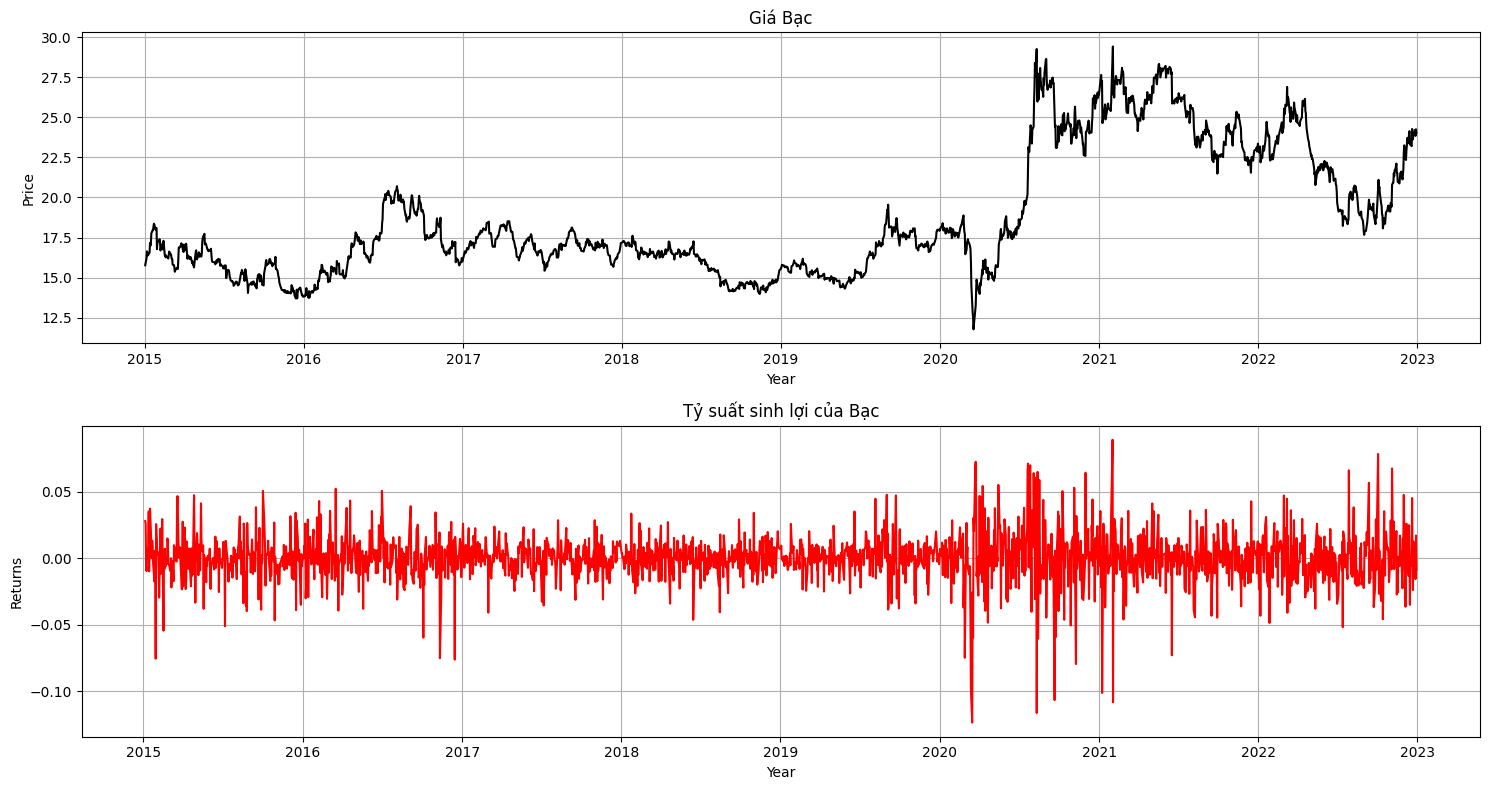

In [55]:
visualize_return_value(df=df_pb,
                       df_r=df_r_pb_temp,
                       df_name='Giá Bạc',
                       df_r_name='Tỷ suất sinh lợi của Bạc')

### 3. Description Statistic

In [56]:
descriptive_statistic(r=r_pb)

Obs       : 2050
Median    : 0.00020337105
Mean      : 0.00020572523
Std. Dev  : 0.01784452
Minimum   : -0.123454094
Maximum   : 0.08896017
Skewness  : -0.5310236013368216
Kurtosis  : 9.377742609847544
Jarque-Bera test: SignificanceResult(statistic=3570.719473718848, pvalue=0.0)


In [57]:
adf_test(r=r_pb)

ADF Statistic: -22.85488341668612
p-value: 0.0
Critical Values: {'1%': -3.433550158004116, '5%': -2.8629536749602478, '10%': -2.5675225771861077}


### 4. ARCH(1)

In [58]:
#Chuyển TSSL sang dạng % cho thuận tiện
rp_pb = r_pb*100

In [59]:
#Ước lượng mô hình ARCH(1)
am0_pb = arch_model(rp_pb, mean = 'Constant', p=1, o=0, q=0, dist=dist)
arch1_pb = am0_pb.fit(update_freq=5, disp = "off")
print("ARCH(1) model:", "\n", arch1_pb.summary(), "\n")
#Kiểm định phần dư của ARCH(1)
arch_stdresid= arch1_pb.resid/arch1_pb.conditional_volatility
arch1lb = acorr_ljungbox(arch_stdresid, lags=[5,10,15,20]) 
print('LB Test Result:','\n',arch1lb)
jb_arch = jarque_bera(arch_stdresid)
print('\nJB Test Result:','\n',jb_arch)

ARCH(1) model: 
                       Constant Mean - ARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -4018.96
Distribution:                  Normal   AIC:                           8043.91
Method:            Maximum Likelihood   BIC:                           8060.79
                                        No. Observations:                 2050
Date:                Sat, Jun 15 2024   Df Residuals:                     2049
Time:                        15:09:41   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -9.6607e-03  3.830e-02  

In [60]:
# LM test
arch1_pb.arch_lm_test(standardized=True)

ARCH-LM Test
H0: Standardized residuals are homoskedastic.
ARCH-LM Test
H1: Standardized residuals are conditionally heteroskedastic.
Statistic: 119.0972
P-value: 0.0000
Distributed: chi2(26)
WaldTestStatistic, id: 0x28fde1e4fe0

### 5. GARCH(1, 1)

In [61]:
#Ước lượng mô hình GARCH(1,1)
am1_pb = arch_model(rp_pb, mean = 'Constant', vol='GARCH', p=1, o=0, q=1, dist=dist)
garch1_1_pb = am1_pb.fit(update_freq=5, disp = "off")
print("GARCH(1,1) model:", "\n", garch1_1_pb.summary(), "\n")

#Kiểm định phần dư của GARCH(1,1)
garch_stdresid= garch1_1_pb.resid/garch1_1_pb.conditional_volatility
garch11lb = acorr_ljungbox(garch_stdresid, lags=[5,10,15,20]) 
print('LB Test Result:','\n',garch11lb)
jb_arch = jarque_bera(garch_stdresid)
print('\nJB Test Result:','\n',jb_arch)

GARCH(1,1) model: 
                      Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3902.21
Distribution:                  Normal   AIC:                           7812.42
Method:            Maximum Likelihood   BIC:                           7834.92
                                        No. Observations:                 2050
Date:                Sat, Jun 15 2024   Df Residuals:                     2049
Time:                        15:09:41   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -8.4434e-03  3.300e-0

### 6. GJR-GARCH(1,1)

In [62]:
#Ước lượng mô hình TGARCH(1,1)
am2_pb = arch_model(rp_pb, mean = 'Constant', vol='GARCH', p=1, o=1, q=1, dist=dist)
gjr_garch1_1_pb = am2_pb.fit(update_freq=5, disp = "off")
print("GJR-GARCH(1,1) model:", "\n", gjr_garch1_1_pb.summary(), "\n")

#Kiểm định phần dư của TGARCH(1,1)
gjr_garch_stdresid= gjr_garch1_1_pb.resid/gjr_garch1_1_pb.conditional_volatility
gjr_garch11lb = acorr_ljungbox(gjr_garch_stdresid, lags=[5,10,15,20]) 
print('LB Test Result:','\n',gjr_garch11lb)
jb_arch = jarque_bera(gjr_garch_stdresid)
print('\nJB Test Result:','\n',jb_arch)

GJR-GARCH(1,1) model: 
                    Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -3900.09
Distribution:                  Normal   AIC:                           7810.18
Method:            Maximum Likelihood   BIC:                           7838.31
                                        No. Observations:                 2050
Date:                Sat, Jun 15 2024   Df Residuals:                     2049
Time:                        15:09:41   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         4.9698e-04  3.361e-0

### 7. EGARCH(1,1)

In [63]:
#Ước lượng mô hình EGARCH(1,1)
am3_pb = arch_model(rp_pb, mean = 'Constant', vol='EGARCH', p=1, o=1, q=1, dist=dist)
exponetial_garch1_1_pb = am3_pb.fit(update_freq=5, disp = "off")
print("EGARCH(1,1) model:", "\n", exponetial_garch1_1_pb.summary(), "\n")

#Kiểm định phần dư của TGARCH(1,1)
egarch_stdresid= exponetial_garch1_1_pb.resid/exponetial_garch1_1_pb.conditional_volatility
egarch11lb = acorr_ljungbox(egarch_stdresid, lags=[5,10,15,20]) 
print('LB Test Result:','\n',egarch11lb)
jb_arch = jarque_bera(egarch_stdresid)
print('\nJB Test Result:','\n',jb_arch)

EGARCH(1,1) model: 
                      Constant Mean - EGARCH Model Results                     
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -3900.49
Distribution:                  Normal   AIC:                           7810.98
Method:            Maximum Likelihood   BIC:                           7839.11
                                        No. Observations:                 2050
Date:                Sat, Jun 15 2024   Df Residuals:                     2049
Time:                        15:09:42   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu            -0.0141  3.494e-02  

### 8. Evaluate

In [64]:
# Đánh giá sai số của mô hình ARCH(1)
rmse_arch1_pb, mae_arch1_pb, mape_arch1_pb, tic_arch1_pb = evaluate_error_of_model(model=am0_pb)
print('ARCH(1):')
print('RMSE: %0.3f' % rmse_arch1_pb)
print('MAE: %0.3f' % mae_arch1_pb) 
print('MAPE: %0.3f' % mape_arch1_pb)
print('TIC: % 0.3f' % tic_arch1_pb)

ARCH(1):
RMSE: 3.313
MAE: 2.994
MAPE: 3.054
TIC:  4.960


In [65]:
# Đánh giá sai số của mô hình GARCH(1,1)
rmse_garch11_pb, mae_garch11_pb, mape_garch11_pb, tic_garch11_pb = evaluate_error_of_model(model=am1_pb)
print('GARCH(1,1):')
print('RMSE: %0.3f' % rmse_garch11_pb)
print('MAE: %0.3f' % mae_garch11_pb) 
print('MAPE: %0.3f' % mape_garch11_pb)
print('TIC: % 0.3f' % tic_garch11_pb)

GARCH(1,1):
RMSE: 4.389
MAE: 3.766
MAPE: 4.171
TIC:  6.184


In [66]:
# Đánh giá sai số của mô hình GJR-ARCH(1,1)
rmse_gjr_garch11_pb, mae_gjr_garch11_pb, mape_gjr_garch11_pb, tic_gjr_garch11_pb = evaluate_error_of_model(model=am2_pb)
print('GJR-GARCH(1,1):')
print('RMSE: %0.3f' % rmse_gjr_garch11_pb)
print('MAE: %0.3f' % mae_gjr_garch11_pb) 
print('MAPE: %0.3f' % mape_gjr_garch11_pb)
print('TIC: % 0.3f' % tic_gjr_garch11_pb)

GJR-GARCH(1,1):
RMSE: 4.731
MAE: 4.152
MAPE: 4.527
TIC:  6.671


In [67]:
# Đánh giá sai số của mô hình EGARCH(1,1)
rmse_egarch11_pb, mae_egarch11_pb, mape_egarch11_pb, tic_egarch11_pb = evaluate_error_of_model(model=am3_pb)
print('EGARCH(1,1):')
print('RMSE: %0.3f' % rmse_egarch11_pb)
print('MAE: %0.3f' % mae_egarch11_pb) 
print('MAPE: %0.3f' % mape_egarch11_pb)
print('TIC: % 0.3f' % tic_egarch11_pb)

EGARCH(1,1):
RMSE: 5.078
MAE: 4.561
MAPE: 4.903
TIC:  7.185


In [68]:
RMSE_value=[rmse_arch1_pb, rmse_garch11_pb, rmse_gjr_garch11_pb, rmse_egarch11_pb]
best_RMSEprediction= np.argmin(RMSE_value)
print('\nBest Forecasting Model (Lowest RMSE):', ['ARCH(1)', 'GARCH(1,1)', 'GJR-GARCH(1_1)', 'EGARCH(1_1)'][best_RMSEprediction])

MAE_value=[mae_arch1_pb, mae_arch1_pb, mae_gjr_garch11_pb, mae_egarch11_pb]
best_MAEprediction= np.argmin(MAE_value)
print('\nBest Forecasting Model (Lowest MAE):', ['ARCH(1)', 'GARCH(1,1)', 'GJR-GARCH(1_1)', 'EGARCH(1_1)'][best_MAEprediction])

MAPE_value=[mape_arch1_pb, mape_garch11_pb, mape_gjr_garch11_pb, mape_egarch11_pb]
best_MAPEprediction= np.argmin(MAPE_value)
print('\nBest Forecasting Model (Lowest MAPE):', ['ARCH(1)', 'GARCH(1,1)', 'GJR-GARCH(1_1)', 'EGARCH(1_1)'][best_MAPEprediction])

TIC_value=[tic_arch1_pb, tic_garch11_pb, tic_gjr_garch11_pb, tic_egarch11_pb]
best_TICprediction= np.argmin(TIC_value)
print('\nBest Forecasting Model (Lowest TIC):', ['ARCH(1)', 'GARCH(1,1)', 'GJR-GARCH(1_1)', 'EGARCH(1_1)'][best_TICprediction])


Best Forecasting Model (Lowest RMSE): ARCH(1)

Best Forecasting Model (Lowest MAE): ARCH(1)

Best Forecasting Model (Lowest MAPE): ARCH(1)

Best Forecasting Model (Lowest TIC): ARCH(1)
